this_means
[ 6.9608603 -6.409355 ]
this_means
[ 0.39992237 -3.860756  ]
this_means
[-2.1096926 -1.9507055]
this_means
[-7.5882397 10.690441 ]
this_means
[-6.388358  -1.5861797]
Means: [Array([ 6.9608603, -6.409355 ], dtype=float32), Array([ 0.39992237, -3.860756  ], dtype=float32), Array([-2.1096926, -1.9507055], dtype=float32), Array([-7.5882397, 10.690441 ], dtype=float32), Array([-6.388358 , -1.5861797], dtype=float32)]
Covariances: [Array([[9.918876 , 7.52409  ],
       [7.52409  , 5.7693143]], dtype=float32), Array([[ 2.8355322, -1.2451959],
       [-1.2451959,  6.3880982]], dtype=float32), Array([[ 2.9355392, -5.134278 ],
       [-5.134278 , 10.18609  ]], dtype=float32), Array([[ 1.2812766, -0.7468594],
       [-0.7468594,  5.195469 ]], dtype=float32), Array([[ 6.1948256,  7.5804567],
       [ 7.5804567, 11.237128 ]], dtype=float32)]
Weights: [0.2, 0.2, 0.2, 0.2, 0.2]


findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following

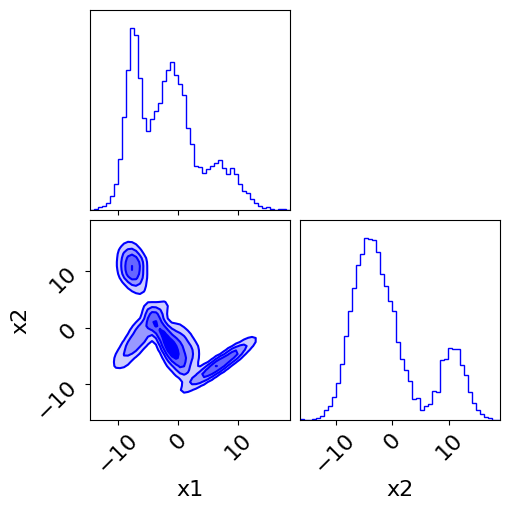

In [2]:
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import corner

np.random.seed(0)
"""The following can be used to improve plotting a bit"""
params = {
        "text.usetex" : False,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16
}

plt.rcParams.update(params)

# Improved corner kwargs -- pass them to corner.corner
default_corner_kwargs = dict(bins=50, 
                        smooth=1.0, 
                        show_titles=False,
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        color="blue",
                        # quantiles=[],
                        # levels=[0.9],
                        plot_density=True, 
                        plot_datapoints=False, 
                        fill_contours=True,
                        max_n_ticks=4, 
                        min_n_ticks=3,
                        truth_color = "red",
                        save=False)

"""Now for the main function"""

def generate_gaussian_mixture(n_dim: int,
                              n_gaussians: int = 5,
                              n_samples: int = 10_000,
                              means: list = None,
                              covariances: list = None,
                              weights: list = None,
                              width_mean: float = 12.0,
                              width_cov: float = 3.0):
    """
    Generate samples from a mixture of Gaussians. 
    This function generates samples from a Gaussian mixture model with specified means, covariances, and weights.
    If means, covariances, or weights are not provided, they are generated randomly.
    
    Args:
        n_dim (int): The number of dimensions for the samples.
        n_gaussians (int, optional): The number of Gaussian components in the mixture. Defaults to 1.
        n_samples (int, optional): The number of samples to generate. Defaults to 10,000.
        means (list, optional): The mean vectors. If not specified, then they will be generated randomly. Defaults to None.
        covariances (list, optional): The square covariance matrix of size (n_dim x n_dim). If not specified, then they will be generated randomly. Defaults to None.
        weights (list, optional): Weights between the different Gaussians. If not specified, equal weights are used. Defaults to None.
        width_mean (float, optional): The width of the mean distribution. Defaults to 10.0.
        width_cov (float, optional): The width of the covariance distribution. Defaults to 1.0.
    """
    
    # If no mean vector is given, generate random means
    seed = np.random.randint(0, 1000)
    jax_key = jax.random.PRNGKey(seed)
    if means is None:
        means = []
        for _ in range(n_gaussians):
            # Split the key to ensure different means for each Gaussian
            jax_key, subkey = jax.random.split(jax_key)
            this_means = jax.random.uniform(subkey, (n_dim,), minval=-width_mean, maxval=width_mean)
            print("this_means")
            print(this_means)
            
            means.append(this_means)
    print(f"Means: {means}")
        
    # If no covariance matrix is given, generate identity matrices
    if covariances is None:
        covariances = []
        for _ in range(n_gaussians):
            jax_key, subkey = jax.random.split(jax_key)
            A = jax.random.uniform(subkey, (n_dim, n_dim), minval=-width_cov, maxval=width_cov)
            B = jnp.dot(A, A.transpose())
            covariances.append(B)
    print(f"Covariances: {covariances}")
    
    # If no weights are given, use equal weights between the Gaussians
    if weights is None:
        weights = [1.0 / n_gaussians] * n_gaussians
    print(f"Weights: {weights}")
        
    # Check if everythingq is consistent
    if len(means) != n_gaussians or len(covariances) != n_gaussians or len(weights) != n_gaussians:
        raise ValueError("Means, covariances, and weights must match the number of Gaussians.")
    
    # Generate samples
    samples = []
    for i in range(n_samples):
        # Choose a Gaussian component based on weights
        this_key = jax.random.PRNGKey(i)
        this_key, sample_key = jax.random.split(this_key)
        component = np.random.choice(n_gaussians, p=weights)
        mean = means[component]
        covariance = covariances[component]
        
        # Generate a sample from the chosen Gaussian
        sample = jax.random.multivariate_normal(sample_key, mean, covariance)
        samples.append(sample)
        
    samples = jnp.array(samples)
    return samples

def main():
    """Small main function to test the Gaussian mixture generation."""
    
    n_dim = 2
    n_gaussians = 5
    weights = None
    # weights = [0.35, 0.15, 0.50]
    # weights = [0.2, 0.2, 0.15, 0.25, 0.2]
    

    samples = generate_gaussian_mixture(n_dim, n_gaussians, weights=weights)

    # Plot the samples
    corner.corner(np.array(samples), labels=[f'x{i+1}' for i in range(n_dim)], **default_corner_kwargs)
    #if weights is None:
        #save_name = f'./figures/gmm_ndim_{n_dim}_ngauss_{n_gaussians}.png'
    #else:
        #save_name = f'./figures/gmm_ndim_{n_dim}_ngauss_{n_gaussians}_weights.png'
    #plt.savefig(save_name)
    #plt.close()
    
if __name__ == "__main__":
    main()

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following

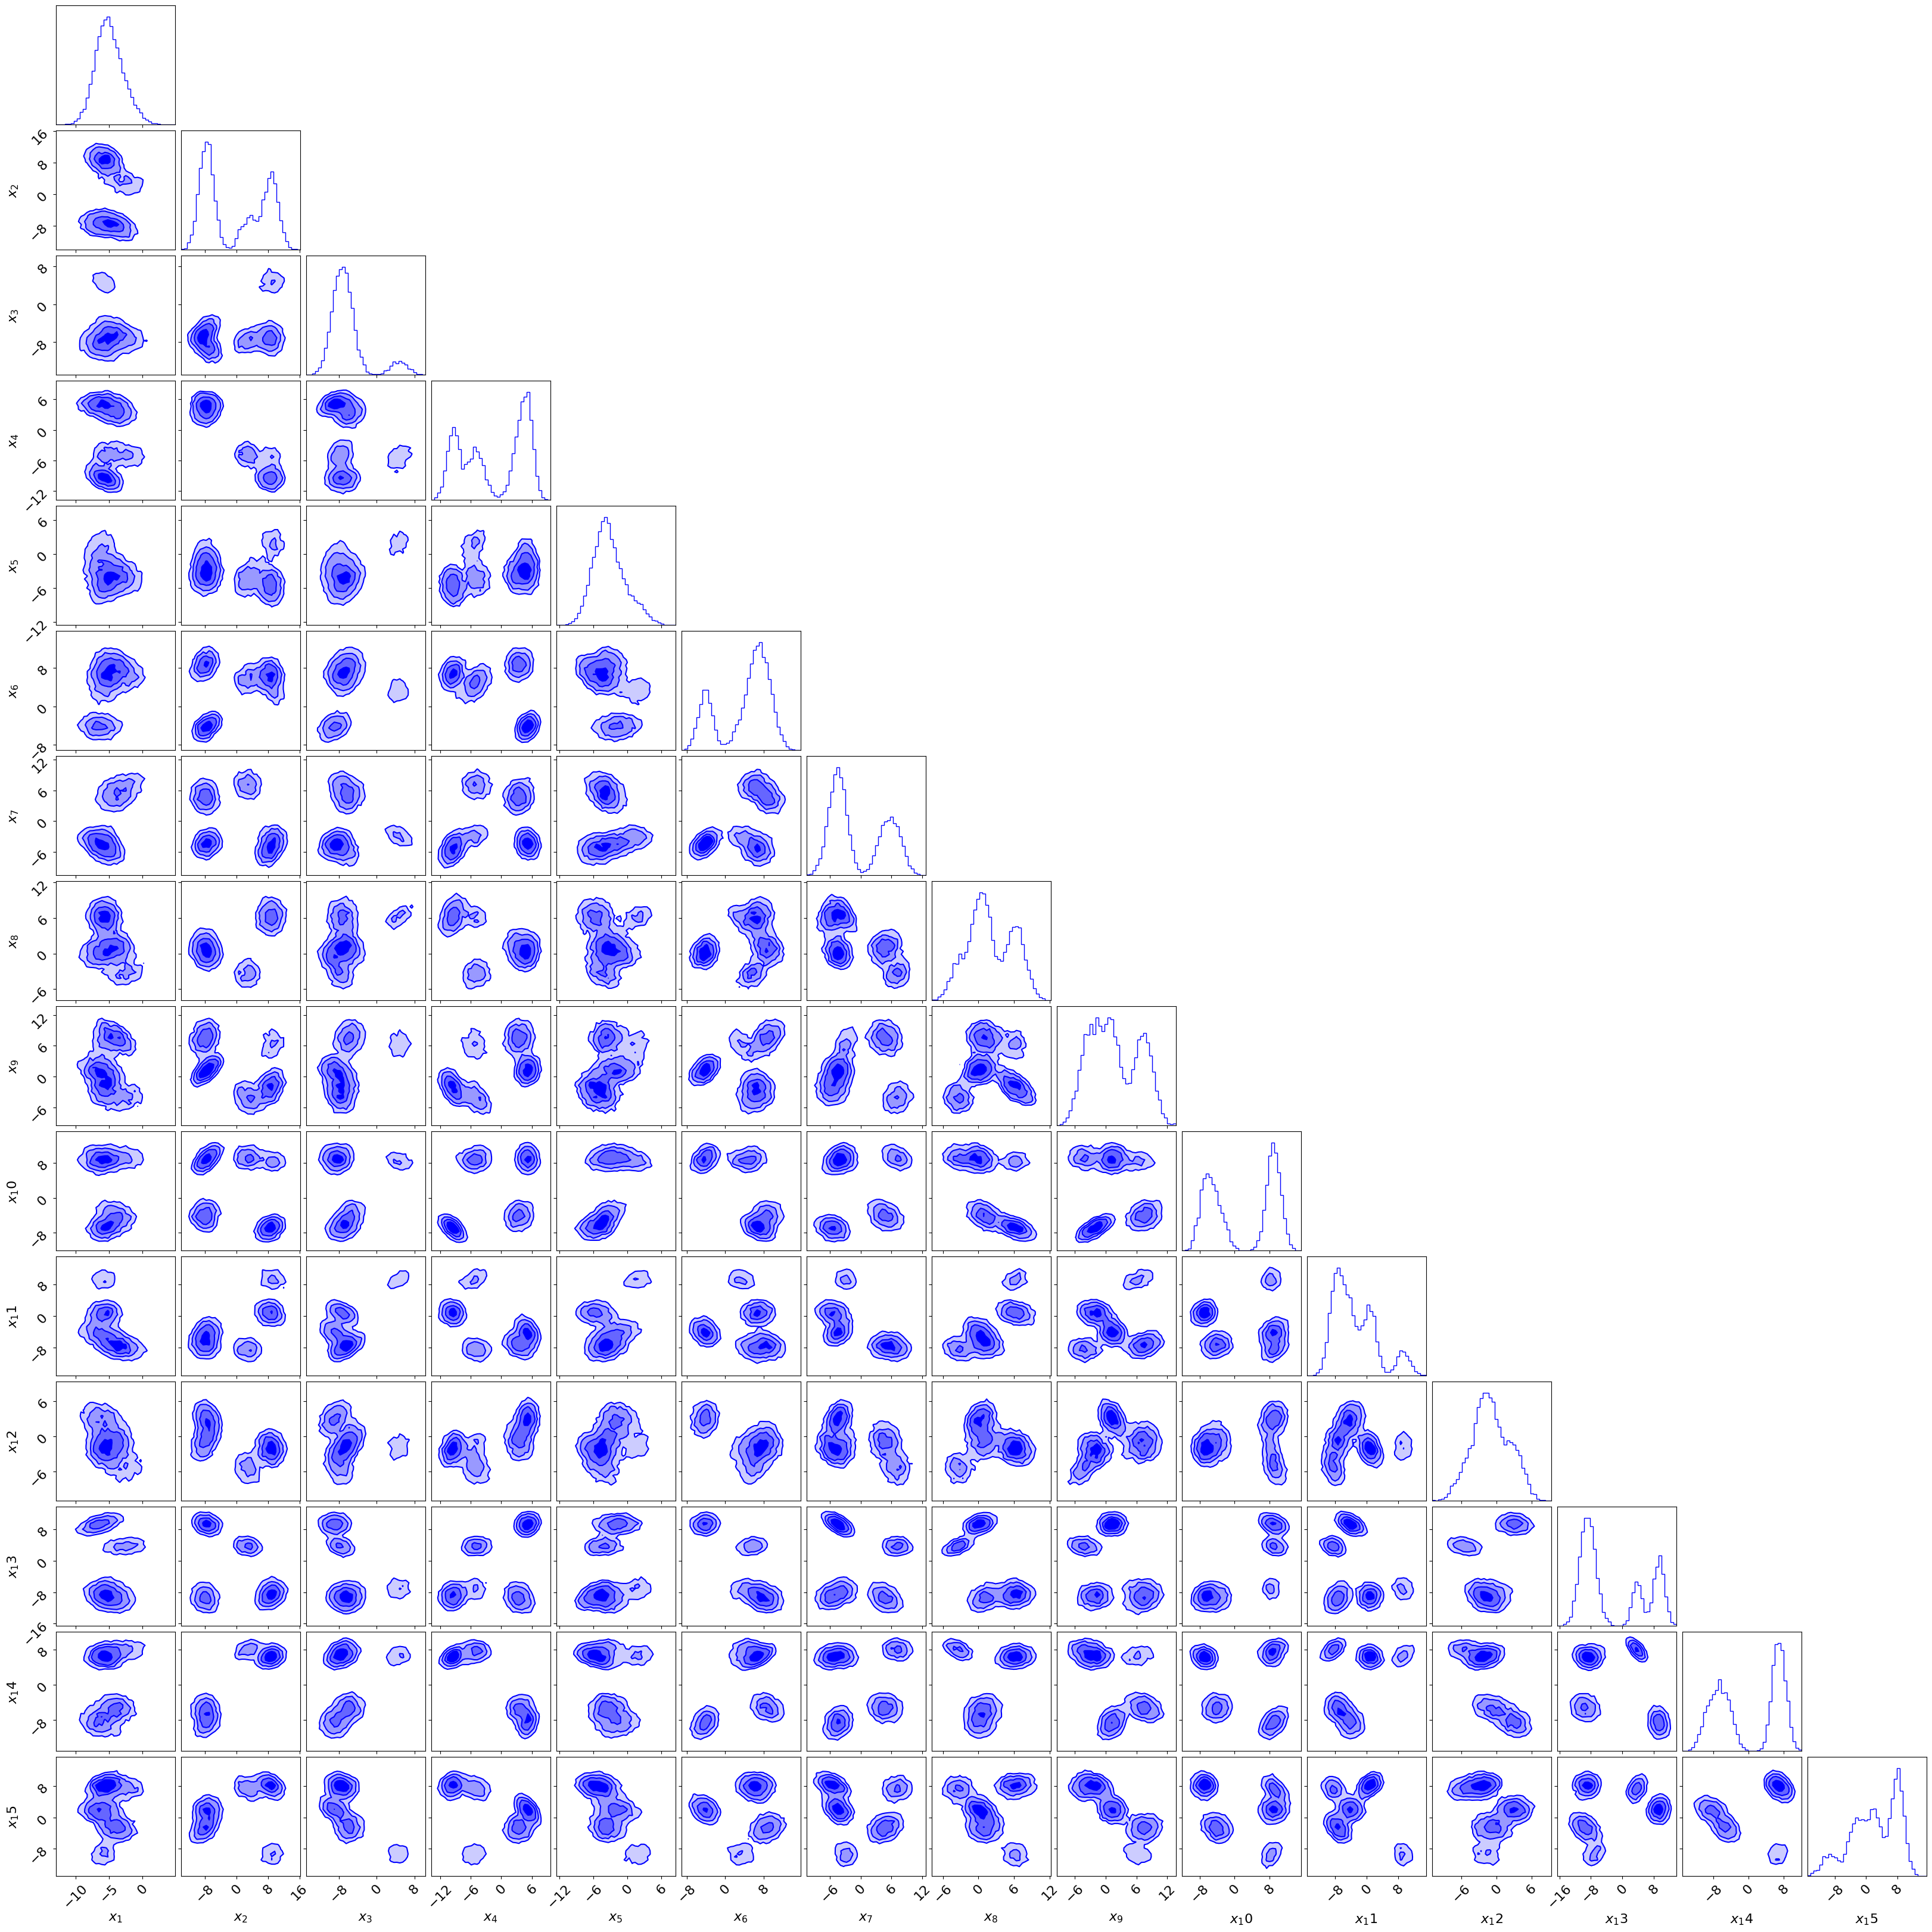

In [20]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import corner


# ---------- plotting set‑up (unchanged) -----------------------------
params = {
    "text.usetex": False,
    "font.family": "serif",
    "ytick.color": "black",
    "xtick.color": "black",
    "axes.labelcolor": "black",
    "axes.edgecolor": "black",
    "font.serif": ["Computer Modern Serif"],
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.labelsize": 16,
    "legend.fontsize": 16,
    "legend.title_fontsize": 16,
    "figure.titlesize": 16,
}
plt.rcParams.update(params)

default_corner_kwargs = dict(
    bins=40,
    smooth=0.55,                # ↓ lower smoothing so modes stay visible
    show_titles=False,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="blue",
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=4,
    min_n_ticks=3,
    truth_color="red",
    save=False,
)

# ---------- main data generator -------------------------------------
def generate_gaussian_mixture(
    n_dim: int,
    n_gaussians: int = 5,
    n_samples: int = 10_000,
    means: list | None = None,
    covariances: list | None = None,
    weights: list | None = None,
    width_mean: float = 10.0,
    sigma: float = 2,          # component width (std‑dev)
    min_separation: float = 2.0, # enforce separation between means
    use_isotropic_cov: bool = True,
):
    """
    Generate samples from a mixture of Gaussians whose individual
    covariances have width `sigma`.

    * If `use_isotropic_cov` is True each component gets Σ = σ² I.
    * Otherwise each component gets a random SPD matrix B
      that is normalised to have max eigen‑value = σ².

    means / covariances / weights can still be supplied explicitly;
    any that are None are generated here.
    """

    rng = np.random.default_rng()
    key = jax.random.PRNGKey(rng.integers(0, 1 << 32))

    # ------------- build means (keep them separated) -----------------
    if means is None:
        means = []
        while len(means) < n_gaussians:
            key, sub = jax.random.split(key)
            cand = jax.random.uniform(sub, (n_dim,), minval=-width_mean, maxval=width_mean)
            # distance test
            if all(jnp.linalg.norm(cand - m) >= min_separation for m in means):
                means.append(cand)
    # ------------- build covariances ---------------------------------
    if covariances is None:
        covariances = []
        for _ in range(n_gaussians):
            if use_isotropic_cov:
                # Σ = σ² I
                covariances.append(jnp.eye(n_dim) * (sigma**2))
            else:
                # random SPD matrix scaled to σ²
                key, sub = jax.random.split(key)
                A = jax.random.uniform(sub, (n_dim, n_dim), minval=-1.0, maxval=1.0)
                B = A @ A.T
                B /= jnp.max(jnp.linalg.eigvalsh(B))  # normalise eigen‑values
                B *= sigma**2
                covariances.append(B)

    # ------------- weights -------------------------------------------
    if weights is None:
        weights = [1.0 / n_gaussians] * n_gaussians

    # ------------- sample --------------------------------------------
    samples = []
    component_ids = rng.choice(n_gaussians, size=n_samples, p=weights)
    for i, comp in enumerate(component_ids):
        key, sub = jax.random.split(key)
        sample = jax.random.multivariate_normal(sub, means[comp], covariances[comp])
        samples.append(sample)
    return jnp.stack(samples)


# ---------- quick test / demo ---------------------------------------
def main():
    n_dim = 15
    n_gaussians = 5
    weights = [0.25, 0.10, 0.25, 0.15, 0.25]

    samples = generate_gaussian_mixture(
        n_dim=n_dim,
        n_gaussians=n_gaussians,
        n_samples=10_000,
        weights=weights,
        sigma=3.0,              # width of each component
        use_isotropic_cov=False # ← flip to True for Σ = σ² I
    )

    corner.corner(np.array(samples),
                  labels=[f"$x_{i+1}$" for i in range(n_dim)],
                  **default_corner_kwargs)
    plt.show()


if __name__ == "__main__":
    main()